# Introduction

### This project report will include
1. Explanation of the purpose, and background on my project
2. A in-depth explanation of my data merging


## Purpose
The purpose of this project report (in notebook form) is to show some exploratory data analysis and data cleaning for this particular project. This project set out to reveal information about the relationship between population demographic information and the uptake in solar power. In particular, the purpose was to determine whether race or income was more significant in solar power uptake. 

## Background
The initial inspiration for this project was a Graduate Mechanical Engineering seminar at Tufts University. The talk, given on Thursday February 7th, 2019, was titled titled “Energy Injustice: Disparities in Rooftop Photovoltaics Deployment in the United States.” The abstract of the talk was as follows: 

“The rooftop solar industry in the United States has experienced dramatic growth—roughly 50% per year since 2012, along with steadily falling prices. Although the opportunities this affords for clean, reliable power are transformative, the benefits might not accrue to all individuals and communities. Combining the location of existing and potential sites for rooftop photovoltaics (PV) from Google’s Project Sunroof and demographic information from the American Community Survey, the relative adoption of rooftop PV is compared across census tracts based on median household income, home ownership, and race and ethnicity. The historical context of energy injustice in this country will be discussed, as well as the importance for engineers today to holistically consider sustainability: environmentally, economically, and socially.”

During the talk, Professor Sunter detailed how she ran regressions on data sets from the American Community Survey (ACS) and Google’s Project Sunroof program to determine the factor that most significantly affects solar power uptake. Since the ACS, which is administered by the US Census Bureau, ties geography to certain population characteristics (e.g. race, income, and age), and the Project Sunroof data set details solar power characteristics (e.g. number of solar panels), she was able statistically detail the effect of race on solar deployment. Since both data sets provided information at the census tract level, that was chosen as the geographic level of interest.  

As a first foray into data science techniques, I will try to replicate the work that Professor Sunter has done. In her paper, “Disparities in rooftop photovoltaics deployment in the United States by race and ethnicity”, Professor Sunter details her methods for determining if there are significant differences between races in solar deployment, all else equal. One significant reason for replication of this study is that the ACS data set that was utilized in the study came from the 2009-2013 5-year ACS. In my project, I will be using the 2012-2017 5-year ACS data set, providing a much more recent set of population characteristics. 

Solar power companies have approached Professor Sunter about the results of her data analysis to determine ways to equalize, from a racial point of view, access and usage of solar power. Solar power has the potential to pay for itself, reducing or eliminating the electricity bill of its users, with the caveat of significant policy differences between states. 


## Initialization
Below are some of the tools that I used to conduct the data exploration and  visuaization. 

In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
from census import Census
from us import states
import time
import os
import re
import pathlib
import urllib
import zipfile
import io
import requests
import matplotlib.pyplot as plt
import pysal as ps
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c
from sklearn.metrics import roc_curve, auc

C:\Users\Vincent\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Acquiring Datasets
There are two data sets that are read into the analysis. The first is the American Community Survey (ACS), part of the US Census's collected data. The particular ACS data that is read in is the 5-year aggregate collected in the years 2013-2017. Using the "census" wrapper (as was suggested by the official Census website), the cell below scrapes the data set, collecting information on total population of all counties. 

I then decided that I would focus mainly on the most populous counties in the US, as a proxy for the popularity of solar panels. This idea was inspired by Google Project Sunroof's machine learning algorithm. The team fed the algorithm mainly aerial imagery from areas that were more dense in their solar panel coverage in order to expose the algorithm to more positive hits. In the code, I sorted all the counties in the US by total county population and then chose a number of those most populous counties to continue on with.



In [2]:
c = Census("293692e0c7b410f968b3f170913992109d637581" , year=2017)
county = c.acs5.get(('NAME', 'B01003_001E'), {'for':'county:*'})
df = pd.DataFrame(county)
countysort = df.sort_values(["B01003_001E"], axis = 0, ascending = False)
countysortshort = countysort.head(25)
css = countysortshort
css

B01003_001E                               NAME county state
296    10105722.0     Los Angeles County, California    037    06
684     5238541.0              Cook County, Illinois    031    17
2791    4525519.0               Harris County, Texas    201    48
175     4155501.0           Maricopa County, Arizona    013    04
283     3283665.0       San Diego County, California    073    06
314     3155816.0          Orange County, California    059    06
431     2702602.0         Miami-Dade County, Florida    086    12
1921    2635121.0             Kings County, New York    047    36
2796    2552213.0               Dallas County, Texas    113    48
297     2355002.0       Riverside County, California    065    06
1916    2339280.0            Queens County, New York    081    36
298     2121220.0  San Bernardino County, California    071    06
3103    2118119.0            King County, Washington    033    53
1849    2112436.0               Clark County, Nevada    003    32
2678    1983675.0              Tarrant County, Texas    439    48
299     1911226.0     Santa Clara County, California    085    06
2778    1892004.0                Bexar County, Texas    029    48
404     1890416.0            Broward County, Florida    011    12
1334    1763822.0             Wayne County, Michigan    163    26
1922    1653877.0          New York County, New York    061    36
279     1629615.0         Alameda County, California    001    06
1273    1582857.0    Middlesex County, Massachusetts    017    25
2335    1569657.0  Philadelphia County, Pennsylvania    101    42
1947    1497595.0           Suffolk County, New York    103    36
280     1495400.0      Sacramento County, California    067    06

Using the Census wrapper, a dataframe called censusdata was built, collecting data on total population, racial demographic information, and income on each of the census tracts in each of those very populous counties. Some data cleaning occurs in the block of code, there are some census tracts with very low populations that were excluded and there were also some negative income values for some census tracts. These census tracts were dropped from the analysis. 

In [3]:
countyData = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[0,3], css.iloc[0,2], Census.ALL))
countyData.head() 

B01003_001E  B02001_002E  B02001_003E  B02001_005E  B03002_012E  \
0       4196.0       2042.0          0.0          0.0       4149.0   
1       2765.0       1294.0         17.0          0.0       2733.0   
2       3589.0       1751.0        156.0       1350.0        321.0   
3       3119.0       1669.0        101.0        425.0       2117.0   
4       2248.0       1243.0         50.0        373.0       1219.0   

   B19013_001E                                               NAME county  \
0      41476.0  Census Tract 5315.04, Los Angeles County, Cali...    037   
1      37022.0  Census Tract 5315.03, Los Angeles County, Cali...    037   
2      87500.0  Census Tract 2060.31, Los Angeles County, Cali...    037   
3      38672.0  Census Tract 1863.01, Los Angeles County, Cali...    037   
4      69250.0  Census Tract 1831.04, Los Angeles County, Cali...    037   

  state   tract  
0    06  531504  
1    06  531503  
2    06  206031  
3    06  186301  
4    06  183104

In [4]:
countyData = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[0,3], css.iloc[0,2], Census.ALL))
for x in range(1,len(css)):
    df = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[x,3], css.iloc[x,2], Census.ALL))
    countyData = countyData.append(df, ignore_index = True)
    #print("I am at step ", x)
print('Out of Loop')
countyData.head()

Out of Loop


B01003_001E  B02001_002E  B02001_003E  B02001_005E  B03002_012E  \
0       4196.0       2042.0          0.0          0.0       4149.0   
1       2765.0       1294.0         17.0          0.0       2733.0   
2       3589.0       1751.0        156.0       1350.0        321.0   
3       3119.0       1669.0        101.0        425.0       2117.0   
4       2248.0       1243.0         50.0        373.0       1219.0   

   B19013_001E                                               NAME county  \
0      41476.0  Census Tract 5315.04, Los Angeles County, Cali...    037   
1      37022.0  Census Tract 5315.03, Los Angeles County, Cali...    037   
2      87500.0  Census Tract 2060.31, Los Angeles County, Cali...    037   
3      38672.0  Census Tract 1863.01, Los Angeles County, Cali...    037   
4      69250.0  Census Tract 1831.04, Los Angeles County, Cali...    037   

  state   tract  
0    06  531504  
1    06  531503  
2    06  206031  
3    06  186301  
4    06  183104

In [5]:
countyData2 = pd.merge(countyData, css, on='county')
countyData2.head()

B01003_001E_x  B02001_002E  B02001_003E  B02001_005E  B03002_012E  \
0         4196.0       2042.0          0.0          0.0       4149.0   
1         2765.0       1294.0         17.0          0.0       2733.0   
2         3589.0       1751.0        156.0       1350.0        321.0   
3         3119.0       1669.0        101.0        425.0       2117.0   
4         2248.0       1243.0         50.0        373.0       1219.0   

   B19013_001E                                             NAME_x county  \
0      41476.0  Census Tract 5315.04, Los Angeles County, Cali...    037   
1      37022.0  Census Tract 5315.03, Los Angeles County, Cali...    037   
2      87500.0  Census Tract 2060.31, Los Angeles County, Cali...    037   
3      38672.0  Census Tract 1863.01, Los Angeles County, Cali...    037   
4      69250.0  Census Tract 1831.04, Los Angeles County, Cali...    037   

  state_x   tract  B01003_001E_y                          NAME_y state_y  
0      06  531504     10105722.0  Los Angeles County, California      06  
1      06  531503     10105722.0  Los Angeles County, California      06  
2      06  206031     10105722.0  Los Angeles County, California      06  
3      06  186301     10105722.0  Los Angeles County, California      06  
4      06  183104     10105722.0  Los Angeles County, California      06

The next block of code allows me to merge data from this data set with any other data set that tracks information by census tract. To provide a bit of background, the census tract numbers include state and county designations. Each state is given a numeric value, and each country within that state is also given a numeric designation. Also each census tract is also given a specific number; designating a specific census tract then requires combining the state, county, and census tract designation numbers into a specific tract ID number. 

This block of code also changes the alphanumeric census variables into vocabulary that is understandable. 



In [6]:
countyData2['tractID'] = countyData2['state_x'].str.cat(countyData2['county'],sep="").str.cat(countyData2['tract'], sep="")
censusdata = countyData2
censusdata.tractID = censusdata.tractID.astype(float)
censusdata.columns = ['TractPopulation', 'White', 'Black', 'Asian', 'Hispanic','Income', 'TractName', 'county', 'state', 'tract', 'CountyPopulation', 'CountyName', 'state2', 'GEOID']
censusdata = censusdata.drop(['tract', 'state2'], axis = 1)
#Edit the following line so that the "censusdata" dataframe is sorted by county population and then by geographic ID
censusdata.sort_values(["CountyPopulation", "GEOID"], axis = 0, ascending = [False, True], inplace=True)

censusdata.head()

TractPopulation   White  Black  Asian  Hispanic   Income  \
1074           4566.0  3374.0   52.0  282.0    1695.0  51209.0   
291            3064.0  2583.0    0.0  253.0     274.0  85460.0   
2232           6043.0  4705.0  172.0  149.0    3187.0  34627.0   
2094           3340.0  2249.0   53.0  395.0    1019.0  40273.0   
1060           4285.0  3734.0  112.0  245.0     398.0  81076.0   

                                              TractName county state  \
1074  Census Tract 1011.10, Los Angeles County, Cali...    037    06   
291   Census Tract 1011.22, Los Angeles County, Cali...    037    06   
2232  Census Tract 1012.10, Los Angeles County, Cali...    037    06   
2094  Census Tract 1012.20, Los Angeles County, Cali...    037    06   
1060  Census Tract 1013, Los Angeles County, California    037    06   

      CountyPopulation                      CountyName         GEOID  
1074        10105722.0  Los Angeles County, California  6.037101e+09  
291         10105722.0  Los Angeles County, California  6.037101e+09  
2232        10105722.0  Los Angeles County, California  6.037101e+09  
2094        10105722.0  Los Angeles County, California  6.037101e+09  
1060        10105722.0  Los Angeles County, California  6.037101e+09

TractPopulation       102
White                 155
Black                 702
Asian                1478
Hispanic              272
Income                171
TractName           14822
county              14822
state               14822
CountyPopulation        0
CountyName          14822
GEOID                   0
dtype: int64

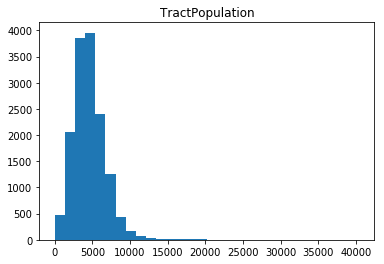

In [7]:
censusdata.hist(column='TractPopulation', bins=30, grid=0)
censusdata[censusdata<1].count()

In [8]:
censusdata[censusdata<1500].count()

TractPopulation       608
White                3705
Black               12813
Asian               13617
Hispanic             9141
Income                171
TractName           14822
county              14822
state               14822
CountyPopulation        0
CountyName          14822
GEOID                   0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002695D50F828>]],
      dtype=object)

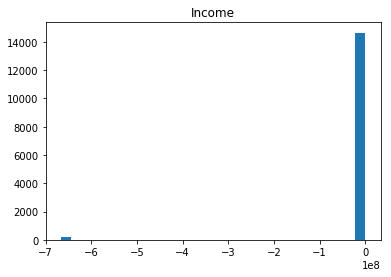

In [9]:
censusdata.hist(column='Income', bins=30, grid=0)

There were some anomalies in the data, particularly apparent in the income column. There are a number of census tracts with negative incomes, these are eliminated in the following cell. Also, there are a number of census tracts with very small or no populations. I've also decided to eliminate the census tracts with populations smaller than 1500. I anticipate that these tracts are rural areas with few (or at least significantly small) populations of non white people and few solar panels. These tracts generally give little to no information at all. 

In [10]:
censusdata.drop(censusdata[censusdata.TractPopulation<1500].index)
censusdata.drop(censusdata[censusdata.Income<0].index)
censusdata.reset_index(drop=True).head()

TractPopulation   White  Black  Asian  Hispanic   Income  \
0           4566.0  3374.0   52.0  282.0    1695.0  51209.0   
1           3064.0  2583.0    0.0  253.0     274.0  85460.0   
2           6043.0  4705.0  172.0  149.0    3187.0  34627.0   
3           3340.0  2249.0   53.0  395.0    1019.0  40273.0   
4           4285.0  3734.0  112.0  245.0     398.0  81076.0   

                                           TractName county state  \
0  Census Tract 1011.10, Los Angeles County, Cali...    037    06   
1  Census Tract 1011.22, Los Angeles County, Cali...    037    06   
2  Census Tract 1012.10, Los Angeles County, Cali...    037    06   
3  Census Tract 1012.20, Los Angeles County, Cali...    037    06   
4  Census Tract 1013, Los Angeles County, California    037    06   

   CountyPopulation                      CountyName         GEOID  
0        10105722.0  Los Angeles County, California  6.037101e+09  
1        10105722.0  Los Angeles County, California  6.037101e+09  
2        10105722.0  Los Angeles County, California  6.037101e+09  
3        10105722.0  Los Angeles County, California  6.037101e+09  
4        10105722.0  Los Angeles County, California  6.037101e+09

## More Data Import: Google Project Sunroof
The next few lines simply put the data from Google Project sunroof into its own dataframe. Additionally, the column that the Sunroof data had called region_name, which stored its own census tract number information, was converted to floats (rather than object data types) and renamed tractID. This is to facilitate the merging of the two datasets using the 'merge' command in pandas. 



In [11]:
start = time.time()
sunroofData = pd.DataFrame(pd.read_csv('https://storage.googleapis.com/project-sunroof/csv/latest/project-sunroof-census_tract.csv'))
sunroofData.region_name = sunroofData.region_name.astype(float)
sunroofData.rename(columns={'region_name':'GEOID'}, inplace=True)
end = time.time()
duration = end-start
print('Operation took', duration, 'seconds')
sunroofData.head()

Operation took 23.553659200668335 seconds


GEOID state_name    lat_max    lat_min    lng_max    lng_min  \
0  1.001020e+09    Alabama  32.505161  32.449730 -86.475128 -86.510422   
1  1.001020e+09    Alabama  32.489342  32.456120 -86.465378 -86.481270   
2  1.001020e+09    Alabama  32.491909  32.459209 -86.450684 -86.470871   
3  1.001020e+09    Alabama  32.493690  32.447208 -86.432381 -86.453941   
4  1.001020e+09    Alabama  32.485748  32.424000 -86.411346 -86.438423   

     lat_avg    lng_avg  yearly_sunlight_kwh_kw_threshold_avg  \
0  32.477184 -86.490082                               1095.65   
1  32.474255 -86.473381                               1095.65   
2  32.475426 -86.460190                               1095.65   
3  32.472000 -86.443619                               1095.65   
4  32.458832 -86.422661                               1095.65   

   count_qualified           ...             yearly_sunlight_kwh_n  \
0            591.0           ...                      6.735739e+05   
1            718.0           ...                      1.354248e+06   
2           1121.0           ...                      2.010001e+06   
3           1491.0           ...                      2.840030e+06   
4           3378.0           ...                      4.317376e+06   

   yearly_sunlight_kwh_s  yearly_sunlight_kwh_e  yearly_sunlight_kwh_w  \
0           3.744787e+06           2.558342e+06           2.776739e+06   
1           4.702247e+06           2.993705e+06           2.978384e+06   
2           7.390340e+06           3.998881e+06           4.096211e+06   
3           1.006799e+07           5.554514e+06           6.354775e+06   
4           2.930909e+07           1.692559e+07           1.866793e+07   

   yearly_sunlight_kwh_f  yearly_sunlight_kwh_median  \
0           2.567009e+06                14854.402856   
1           6.819697e+06                13564.145190   
2           8.226100e+06                12725.930640   
3           4.816764e+06                16586.321436   
4           2.059855e+07                17536.774170   

   yearly_sunlight_kwh_total  \
0               1.232045e+07   
1               1.884828e+07   
2               2.572153e+07   
3               2.963407e+07   
4               8.981854e+07   

                        install_size_kw_buckets_json  \
0  [[0,76],[5,163],[10,136],[15,78],[20,52],[25,2...   
1  [[0,122],[5,200],[10,168],[15,89],[20,46],[25,...   
2  [[0,167],[5,363],[10,258],[15,150],[20,61],[25...   
3  [[0,174],[5,332],[10,350],[15,285],[20,185],[2...   
4  [[0,151],[5,737],[10,1047],[15,758],[20,345],[...   

   carbon_offset_metric_tons  existing_installs_count  
0                7325.568357                      0.0  
1               11206.925804                      0.0  
2               15293.664803                      1.0  
3               17620.007964                      0.0  
4               53404.855511                      8.0  

[5 rows x 31 columns]

Originally, merging was attempted using an if statement nested within a for loop which was nested in another for loop. Then the sunroofData and the censusData dataframes were merged using the 'merge' command. This massively improved the time that it took to combine the two dataframes. 

In [12]:
start = time.time()
combined = pd.merge(censusdata,sunroofData)
end = time.time()
total = end-start
print('Operation took', total, ' seconds.')
combined.head()

Operation took 0.2528541088104248  seconds.


TractPopulation   White  Black  Asian  Hispanic   Income  \
0           4566.0  3374.0   52.0  282.0    1695.0  51209.0   
1           3064.0  2583.0    0.0  253.0     274.0  85460.0   
2           6043.0  4705.0  172.0  149.0    3187.0  34627.0   
3           3340.0  2249.0   53.0  395.0    1019.0  40273.0   
4           4285.0  3734.0  112.0  245.0     398.0  81076.0   

                                           TractName county state  \
0  Census Tract 1011.10, Los Angeles County, Cali...    037    06   
1  Census Tract 1011.22, Los Angeles County, Cali...    037    06   
2  Census Tract 1012.10, Los Angeles County, Cali...    037    06   
3  Census Tract 1012.20, Los Angeles County, Cali...    037    06   
4  Census Tract 1013, Los Angeles County, California    037    06   

   CountyPopulation           ...            yearly_sunlight_kwh_n  \
0        10105722.0           ...                     140187.74881   
1        10105722.0           ...                     276996.80946   
2        10105722.0           ...                     295955.81687   
3        10105722.0           ...                      95976.70462   
4        10105722.0           ...                     442640.01109   

   yearly_sunlight_kwh_s yearly_sunlight_kwh_e  yearly_sunlight_kwh_w  \
0           5.557341e+06          1.884887e+06           3.657478e+06   
1           7.289458e+06          3.498169e+06           5.085950e+06   
2           3.007513e+06          7.046530e+05           1.560988e+06   
3           3.039491e+06          1.470995e+06           2.467520e+06   
4           8.054853e+06          4.014203e+06           4.341075e+06   

   yearly_sunlight_kwh_f  yearly_sunlight_kwh_median  \
0           4.313453e+06                10214.202844   
1           1.913791e+06                14681.464380   
2           8.864574e+06                12548.251587   
3           2.862239e+06                10229.786316   
4           8.763948e+06                14164.059668   

   yearly_sunlight_kwh_total  \
0               1.555335e+07   
1               1.806436e+07   
2               1.443368e+07   
3               9.936221e+06   
4               2.561672e+07   

                        install_size_kw_buckets_json  \
0  [[0,347],[5,461],[10,156],[15,55],[20,15],[25,...   
1  [[0,201],[5,439],[10,340],[15,135],[20,38],[25...   
2  [[0,167],[5,157],[10,78],[15,35],[20,23],[25,2...   
3  [[0,213],[5,254],[10,116],[15,34],[20,13],[25,...   
4  [[0,238],[5,501],[10,360],[15,132],[20,50],[25...   

   carbon_offset_metric_tons  existing_installs_count  
0                4240.324983                     12.0  
1                4924.906272                     43.0  
2                3935.070036                      0.0  
3                2708.922091                      7.0  
4                6983.912268                     24.0  

[5 rows x 42 columns]

To simplify the dataframe, the following cell eliminates the variables that are not relevant; this just makes it easier to view the relevant data. 

In [13]:
combined = combined.drop(columns = ['lat_max', 'lat_min', 'lng_max', 'lng_min', 'lat_avg', 'lng_avg', 'yearly_sunlight_kwh_kw_threshold_avg', 'count_qualified', 'percent_covered', 'percent_qualified', 'number_of_panels_n', 'number_of_panels_s', 'number_of_panels_e', 'number_of_panels_w', 'number_of_panels_f', 'number_of_panels_median', 'kw_median', 'kw_total', 'yearly_sunlight_kwh_n', 'yearly_sunlight_kwh_s', 'yearly_sunlight_kwh_e', 'yearly_sunlight_kwh_w', 'yearly_sunlight_kwh_f', 'yearly_sunlight_kwh_median', 'yearly_sunlight_kwh_total', 'install_size_kw_buckets_json', 'carbon_offset_metric_tons', 'existing_installs_count'])

Now we can look at the combined dataframe and see the relevant columns.

In [14]:
combined.head()

TractPopulation   White  Black  Asian  Hispanic   Income  \
0           4566.0  3374.0   52.0  282.0    1695.0  51209.0   
1           3064.0  2583.0    0.0  253.0     274.0  85460.0   
2           6043.0  4705.0  172.0  149.0    3187.0  34627.0   
3           3340.0  2249.0   53.0  395.0    1019.0  40273.0   
4           4285.0  3734.0  112.0  245.0     398.0  81076.0   

                                           TractName county state  \
0  Census Tract 1011.10, Los Angeles County, Cali...    037    06   
1  Census Tract 1011.22, Los Angeles County, Cali...    037    06   
2  Census Tract 1012.10, Los Angeles County, Cali...    037    06   
3  Census Tract 1012.20, Los Angeles County, Cali...    037    06   
4  Census Tract 1013, Los Angeles County, California    037    06   

   CountyPopulation                      CountyName         GEOID  state_name  \
0        10105722.0  Los Angeles County, California  6.037101e+09  California   
1        10105722.0  Los Angeles County, California  6.037101e+09  California   
2        10105722.0  Los Angeles County, California  6.037101e+09  California   
3        10105722.0  Los Angeles County, California  6.037101e+09  California   
4        10105722.0  Los Angeles County, California  6.037101e+09  California   

   number_of_panels_total  
0                 40063.0  
1                 46562.0  
2                 37021.0  
3                 25669.0  
4                 66070.0

I wanted to check the relevant state numbers for the combined dataframe. This will allow me to create distinct URLs for downloading the relevant states shapefiles. From there, we will merge in the relevant county-level information for creating choropleth maps. 

In [15]:
combined.groupby('state').count()

TractPopulation  White  Black  Asian  Hispanic  Income  TractName  \
state                                                                      
04                 937    937    937    937       937     937        937   
06                5660   5660   5660   5660      5660    5660       5660   
12                 796    796    796    796       796     796        796   
17                1364   1364   1364   1364      1364    1364       1364   
25                 290    290    290    290       290     290        290   
26                 635    635    635    635       635     635        635   
32                 410    410    410    410       410     410        410   
36                2292   2292   2292   2292      2292    2292       2292   
42                 429    429    429    429       429     429        429   
48                2148   2148   2148   2148      2148    2148       2148   
53                 450    450    450    450       450     450        450   

       county  CountyPopulation  CountyName  GEOID  state_name  \
state                                                            
04        937               937         937    937         937   
06       5660              5660        5660   5660        5660   
12        796               796         796    796         796   
17       1364              1364        1364   1364        1364   
25        290               290         290    290         290   
26        635               635         635    635         635   
32        410               410         410    410         410   
36       2292              2292        2292   2292        2292   
42        429               429         429    429         429   
48       2148              2148        2148   2148        2148   
53        450               450         450    450         450   

       number_of_panels_total  
state                          
04                        893  
06                       5312  
12                        736  
17                       1277  
25                        279  
26                        607  
32                        400  
36                       2019  
42                        384  
48                       2021  
53                        396

The following block of code combs through the state column of the combined dataframe and collects distinct values of states; there may be some repeats due to states having multiple counties with very large populations.

In [16]:
stnum = [combined.loc[0,'county']]
stnumarray = []
index = 0
while index < len(combined):
    if stnum == combined.loc[index,'county']:
        index = index + 1
    else:
        stnum = combined.loc[index,'county'];
        temp = combined.loc[index,'state']
        stnumarray.append(temp)
        index = index + 1
stnumarray

['06',
 '17',
 '48',
 '04',
 '06',
 '06',
 '12',
 '36',
 '48',
 '06',
 '36',
 '06',
 '53',
 '32',
 '48',
 '06',
 '48',
 '12',
 '26',
 '36',
 '06',
 '25',
 '42',
 '36',
 '06',
 '06']

This block creates the aforementioned URLs for downloading the shapefiles from the US census website. 

In [17]:
state_url = []
for x in range(0,len(css)):
    temp = "https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_"+ stnumarray[x] + "_tract.zip"
    state_url.append(temp)
state_url

['https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_06_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_17_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_48_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_04_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_06_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_06_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_12_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_36_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_48_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_06_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_36_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_06_tract.zip',
 'https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_53_tract.zip',
 'https://www2.census.gov

The cell below downloads the shapefiles for the all the census tracts in the states in interest. I found that downloading these shapefiles took quite sometime, so I added a print command to tell me when each state's shapefiles was downloaded. These shapefiles (and some other associated files) are then saved locally. The last two lines in this cell then save the filenames 

In [18]:
r = []
for x in range(0, len(state_url)):
    r = requests.get(state_url[x])
    z = zipfile.ZipFile(io.BytesIO(r.content), 'r')
    z.extractall(path=None)
    print('Finished with', x+1, 'states')
print ('Done')

Finished with 1 states
Finished with 2 states
Finished with 3 states
Finished with 4 states
Finished with 5 states
Finished with 6 states
Finished with 7 states
Finished with 8 states
Finished with 9 states
Finished with 10 states
Finished with 11 states
Finished with 12 states
Finished with 13 states
Finished with 14 states
Finished with 15 states
Finished with 16 states
Finished with 17 states
Finished with 18 states
Finished with 19 states
Finished with 20 states
Finished with 21 states
Finished with 22 states
Finished with 23 states
Finished with 24 states
Finished with 25 states
Done


The following for loop saves the filenames of the previously downloaded shapefiles, reads those files and then saves each states' shapefiles inside a cell within a list. The list "tracts" is made up of a number of dataframes, each housed within its own cell. 

In [19]:
tracts = []
for x in range(0,len(state_url)):
    filename = "tl_2017_" + stnumarray[x]+ "_tract.shp"
    temp = gpd.read_file(filename)
    tracts.append(temp)

In [20]:
tracts[0].head()

STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      06      001  442700  06001442700     4427     Census Tract 4427  G5020   
1      06      001  442800  06001442800     4428     Census Tract 4428  G5020   
2      06      037  204920  06037204920  2049.20  Census Tract 2049.20  G5020   
3      06      037  205110  06037205110  2051.10  Census Tract 2051.10  G5020   
4      06      037  205120  06037205120  2051.20  Census Tract 2051.20  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  1234034       0  +37.5371514  -122.0081094   
1        S  1278647       0  +37.5293619  -121.9931002   
2        S   909972       0  +34.0175004  -118.1974975   
3        S   286962       0  +34.0245059  -118.2142985   
4        S  1466129       0  +34.0187546  -118.2117956   

                                            geometry  
0  POLYGON ((-122.017211 37.539323, -122.017186 3...  
1  POLYGON ((-122.002301 37.529836, -122.002236 3...  
2  POLYGON ((-118.202837 34.019657, -118.202829 3...  
3  POLYGON ((-118.219635 34.026285, -118.219449 3...  
4  POLYGON ((-118.220227 34.020564, -118.220183 3...

The next step was to convert the values in the "COUNTYFP" column into float variable types. This will allow us to merge these "tracts" dataframes with the 'combined' dataframe and then plot each individual county's data in choropleth maps

In [21]:
for x in range(0,len(tracts)):
    tracts[x].COUNTYFP = tracts[x].COUNTYFP.astype(float)
tracts[0].head()

STATEFP  COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
0      06       1.0  442700  06001442700     4427     Census Tract 4427   
1      06       1.0  442800  06001442800     4428     Census Tract 4428   
2      06      37.0  204920  06037204920  2049.20  Census Tract 2049.20   
3      06      37.0  205110  06037205110  2051.10  Census Tract 2051.10   
4      06      37.0  205120  06037205120  2051.20  Census Tract 2051.20   

   MTFCC FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0  G5020        S  1234034       0  +37.5371514  -122.0081094   
1  G5020        S  1278647       0  +37.5293619  -121.9931002   
2  G5020        S   909972       0  +34.0175004  -118.1974975   
3  G5020        S   286962       0  +34.0245059  -118.2142985   
4  G5020        S  1466129       0  +34.0187546  -118.2117956   

                                            geometry  
0  POLYGON ((-122.017211 37.539323, -122.017186 3...  
1  POLYGON ((-122.002301 37.529836, -122.002236 3...  
2  POLYGON ((-118.202837 34.019657, -118.202829 3...  
3  POLYGON ((-118.219635 34.026285, -118.219449 3...  
4  POLYGON ((-118.220227 34.020564, -118.220183 3...

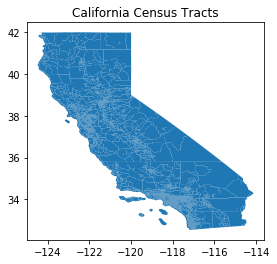

In [22]:
#Checking that this choropleth map plotting actually works. 
ax = tracts[0].plot()
ax.set_title("California Census Tracts");

I needed to create a way to cut up the combined dataframe into each of the sections that corresponded to the counties that I wanted to look at. The following two cells run through the 'combined' dataframe and isolates the different values for county. Every time the 'county' column changes its value, that new value is saved within 'ctynumarray'. The second cell then gows through the 'tracts' list and compares the respective value of 'ctynumarray' to the 'COUNTYFP' column. If those values are the same, then that section of 'tracts' is saved in another list called 'toptract'. 

In [23]:
ctynum = [combined.loc[0,'county']]
ctynumarray = []
index = 0
while index < len(combined):
    if ctynum == combined.loc[index,'county']:
        index = index + 1
    else:
        ctynum = combined.loc[index,'county'];
        ctynumarray.append(ctynum)
        index = index + 1
ctynumarray = [float(i) for i in ctynumarray]
ctynumarray

[37.0,
 31.0,
 201.0,
 13.0,
 73.0,
 59.0,
 86.0,
 47.0,
 113.0,
 65.0,
 81.0,
 71.0,
 33.0,
 3.0,
 439.0,
 85.0,
 29.0,
 11.0,
 163.0,
 61.0,
 1.0,
 17.0,
 101.0,
 103.0,
 67.0]

In [24]:
toptracts = []
toptract = []
for x in range(0,len(tracts)):
    temp = tracts[x]
    temp2 = temp.loc[temp['COUNTYFP'] == ctynumarray[x]]
    toptracts.append(temp2)
    toptract.append(toptracts[x].reset_index(drop = True))
toptract[0].head()

STATEFP  COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
0      06      37.0  204920  06037204920  2049.20  Census Tract 2049.20   
1      06      37.0  205110  06037205110  2051.10  Census Tract 2051.10   
2      06      37.0  205120  06037205120  2051.20  Census Tract 2051.20   
3      06      37.0  206010  06037206010  2060.10  Census Tract 2060.10   
4      06      37.0  206020  06037206020  2060.20  Census Tract 2060.20   

   MTFCC FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0  G5020        S   909972       0  +34.0175004  -118.1974975   
1  G5020        S   286962       0  +34.0245059  -118.2142985   
2  G5020        S  1466129       0  +34.0187546  -118.2117956   
3  G5020        S  1418138   20551  +34.0682177  -118.2320356   
4  G5020        S   843243   30290  +34.0571230  -118.2311021   

                                            geometry  
0  POLYGON ((-118.202837 34.019657, -118.202829 3...  
1  POLYGON ((-118.219635 34.026285, -118.219449 3...  
2  POLYGON ((-118.220227 34.020564, -118.220183 3...  
3  POLYGON ((-118.239236 34.067257, -118.237999 3...  
4  POLYGON ((-118.237866 34.054271, -118.237839 3...

We are getting to the grand finale of the plotting section of this project. I merge the 'combined' dataframe with each part of the 'toptract' list. The result is another list (composed of dataframes for each county of interest) called 'combined2'. 

In [25]:
for x in range(0,len(toptracts)):
    toptract[x].GEOID = toptract[x].GEOID.astype(float)
combined2 = []
for x in range(0,len(toptracts)):
    temp = pd.merge(toptract[x], combined)
    combined2.append(temp)

In [26]:
combined2[0].head()

STATEFP  COUNTYFP TRACTCE         GEOID     NAME              NAMELSAD  \
0      06      37.0  204920  6.037205e+09  2049.20  Census Tract 2049.20   
1      06      37.0  205110  6.037205e+09  2051.10  Census Tract 2051.10   
2      06      37.0  205120  6.037205e+09  2051.20  Census Tract 2051.20   
3      06      37.0  206010  6.037206e+09  2060.10  Census Tract 2060.10   
4      06      37.0  206020  6.037206e+09  2060.20  Census Tract 2060.20   

   MTFCC FUNCSTAT    ALAND  AWATER          ...             Asian Hispanic  \
0  G5020        S   909972       0          ...               0.0   2627.0   
1  G5020        S   286962       0          ...             127.0   3712.0   
2  G5020        S  1466129       0          ...              49.0   3237.0   
3  G5020        S  1418138   20551          ...            1137.0   2032.0   
4  G5020        S   843243   30290          ...             196.0   3444.0   

    Income                                          TractName  county  state  \
0  40871.0  Census Tract 2049.20, Los Angeles County, Cali...     037     06   
1  43063.0  Census Tract 2051.10, Los Angeles County, Cali...     037     06   
2  28558.0  Census Tract 2051.20, Los Angeles County, Cali...     037     06   
3  27669.0  Census Tract 2060.10, Los Angeles County, Cali...     037     06   
4  96719.0  Census Tract 2060.20, Los Angeles County, Cali...     037     06   

   CountyPopulation                      CountyName  state_name  \
0        10105722.0  Los Angeles County, California  California   
1        10105722.0  Los Angeles County, California  California   
2        10105722.0  Los Angeles County, California  California   
3        10105722.0  Los Angeles County, California  California   
4        10105722.0  Los Angeles County, California  California   

  number_of_panels_total  
0                64925.0  
1                 7563.0  
2               108146.0  
3                69998.0  
4                46003.0  

[5 rows x 26 columns]

Finally, each county's information is plotted in the following cell. You may want to view this on a large computer screen. I was not able to create a more easily viewable set of choropleth maps.

C:\Users\Vincent\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Vincent\Anaconda3\lib\site-packages\mapclassify\classifiers.py:276: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
C:\Users\Vincent\Anaconda3\lib\site-packages\mapclassify\classifiers.py:276: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
C:\Users\Vincent\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
C:\Users\Vincent\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid val

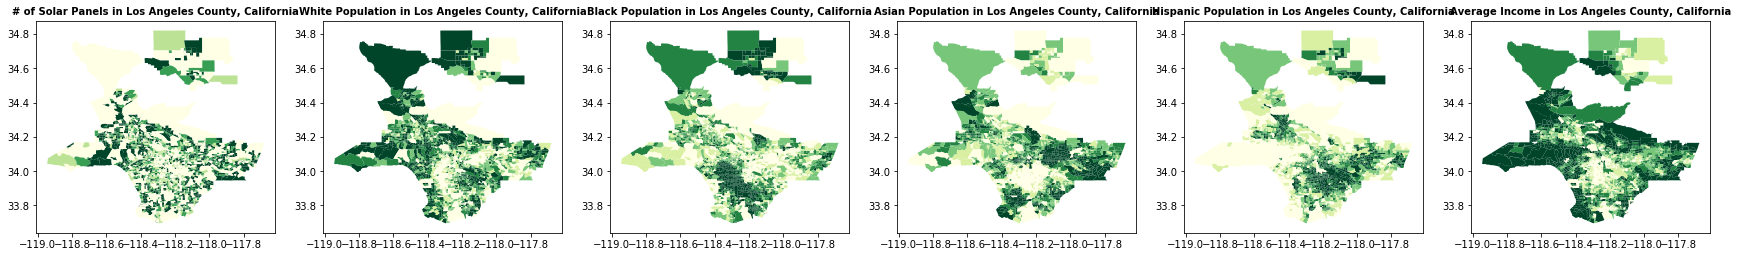

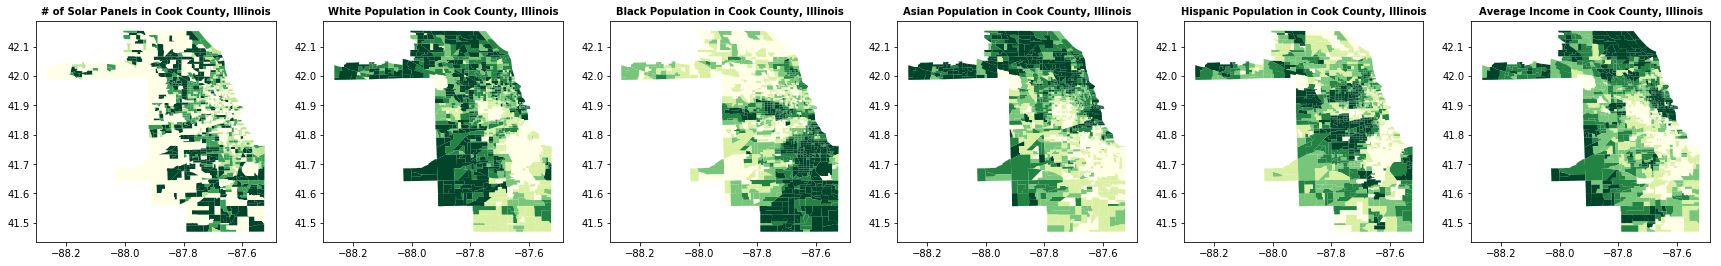

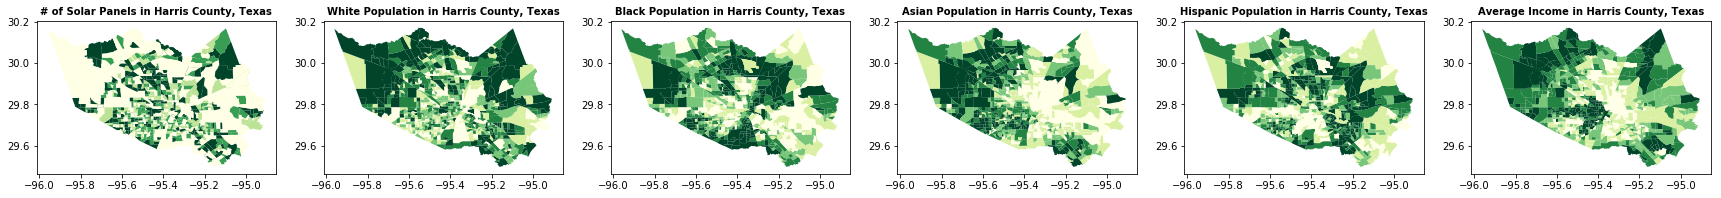

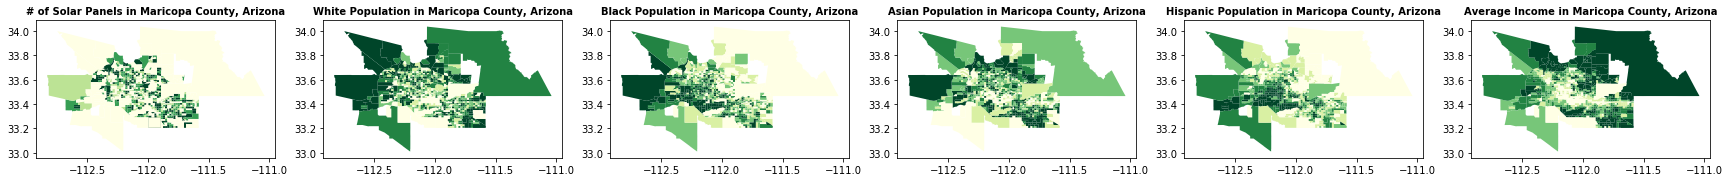

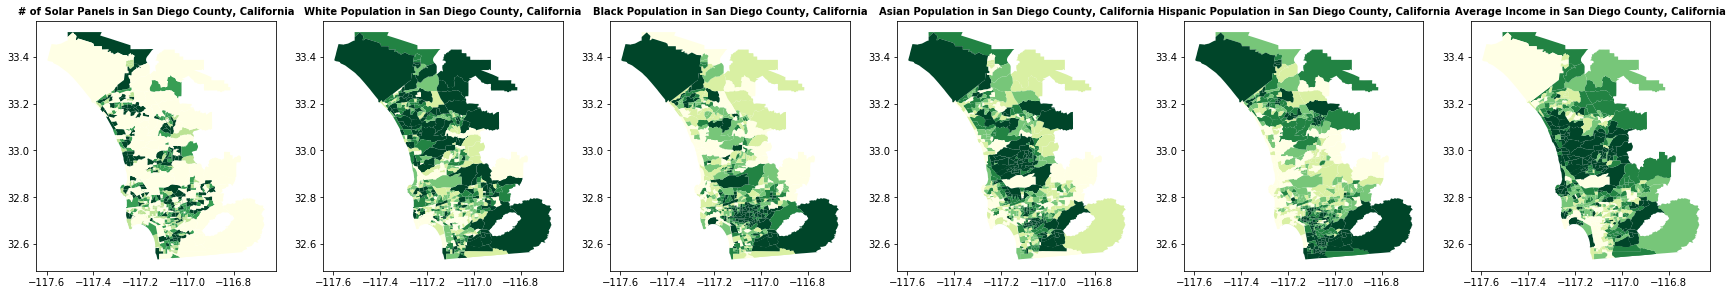

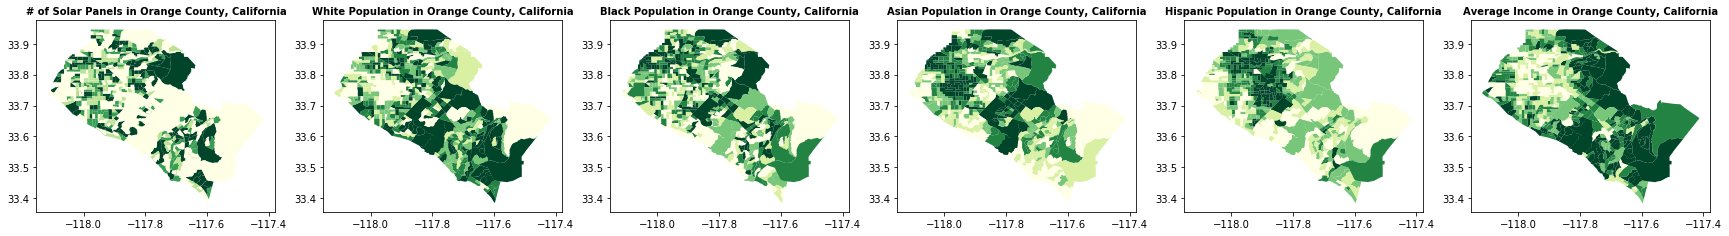

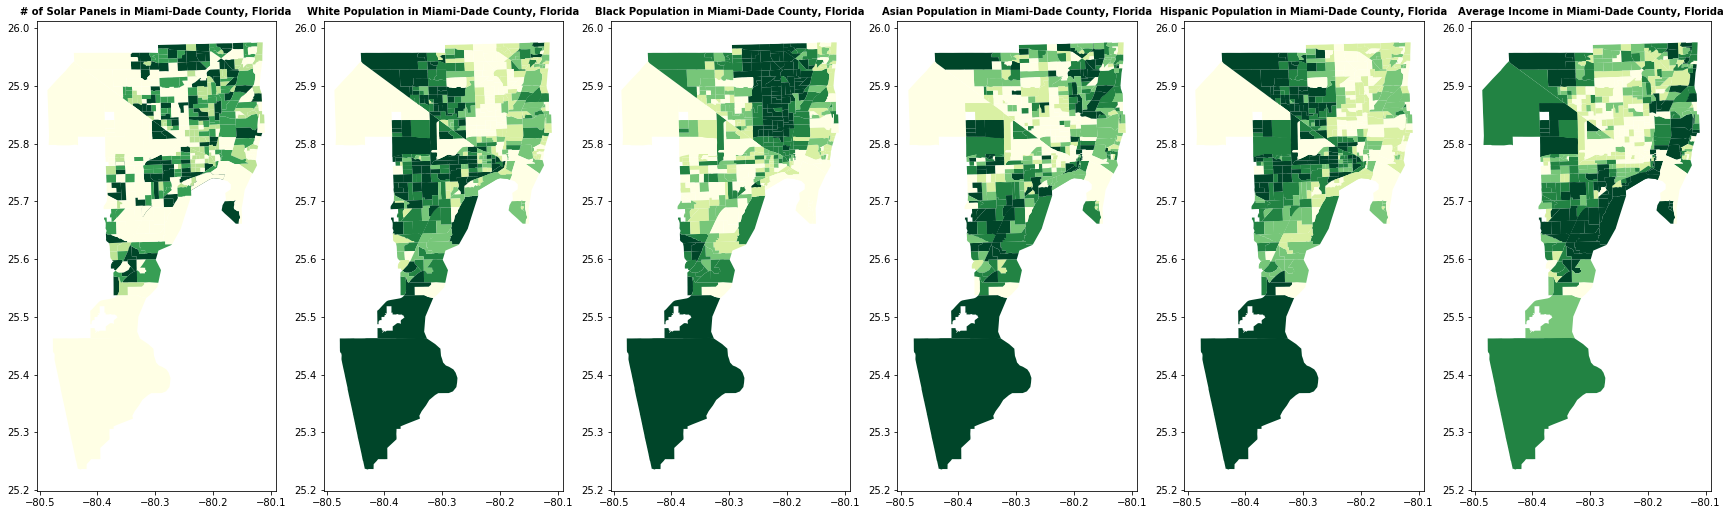

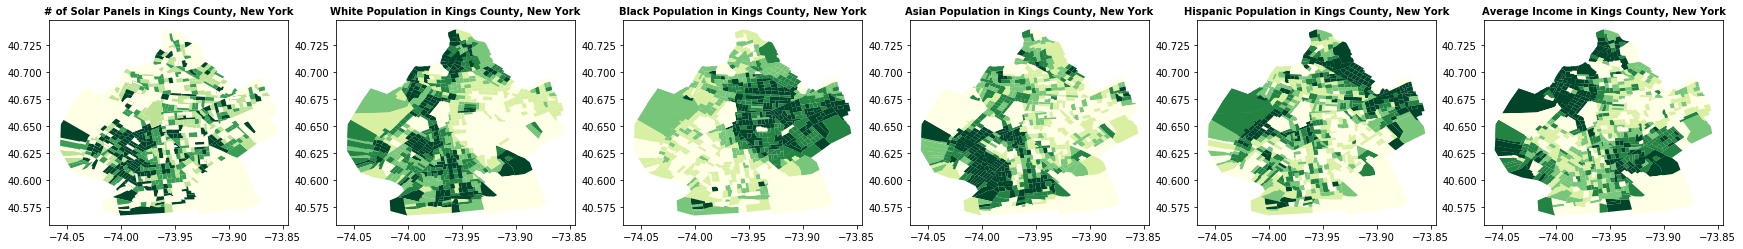

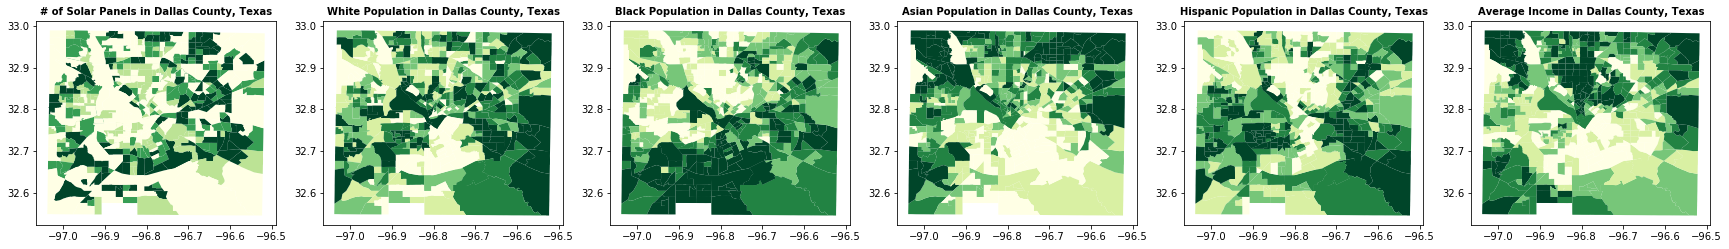

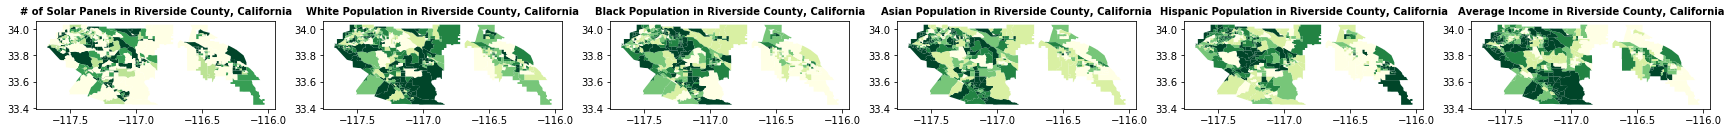

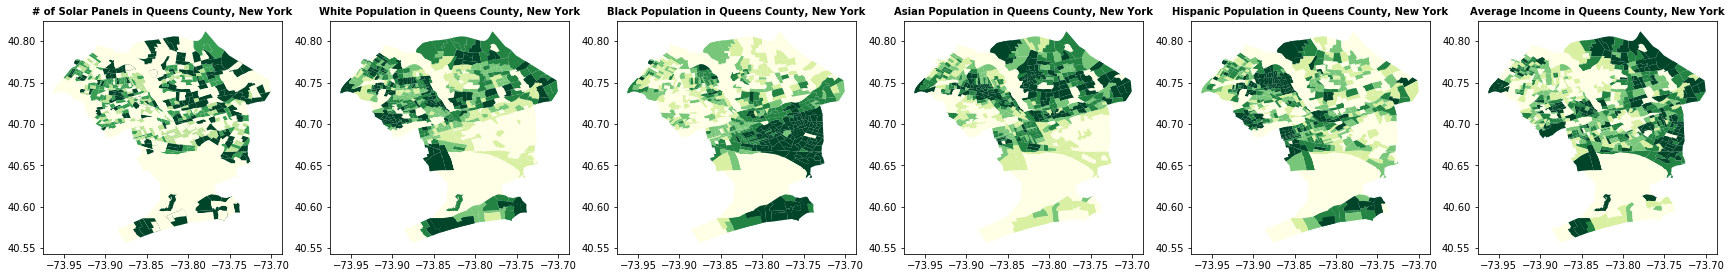

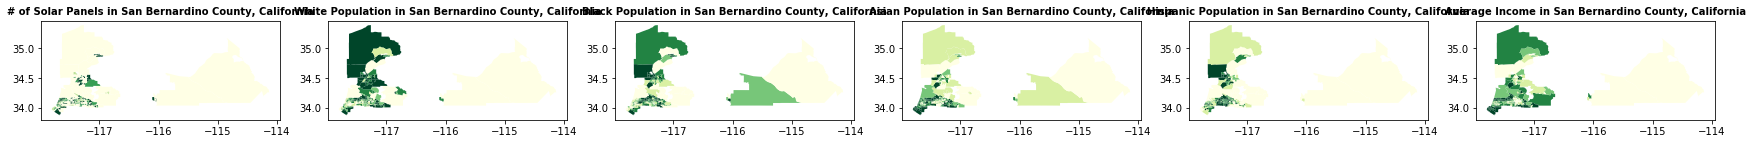

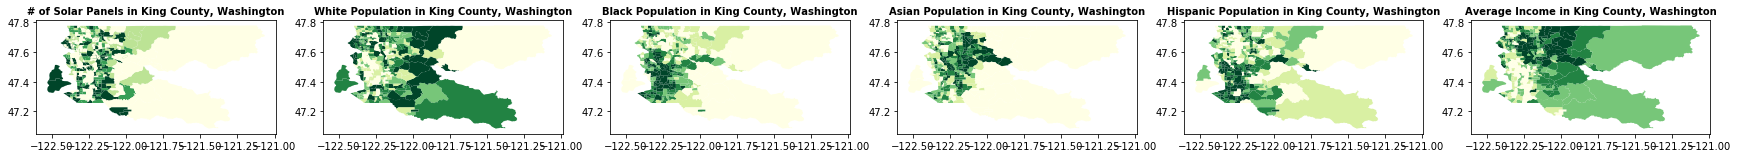

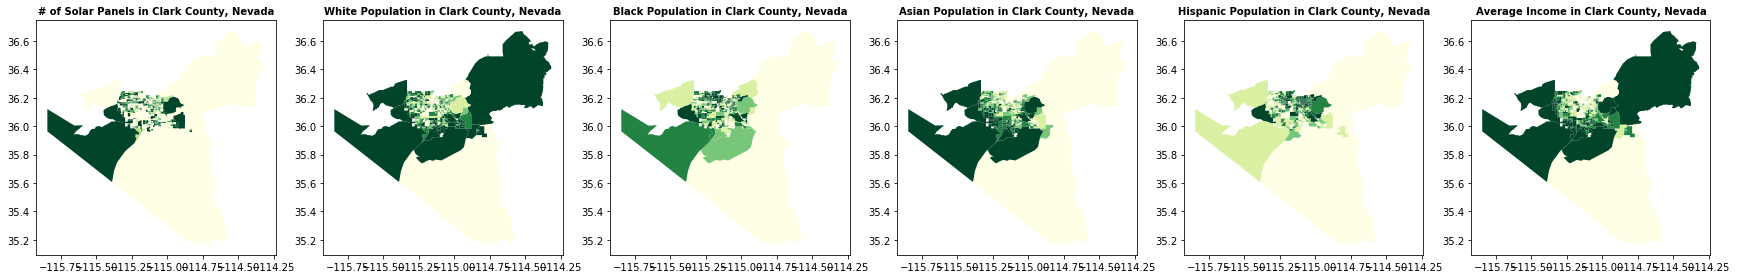

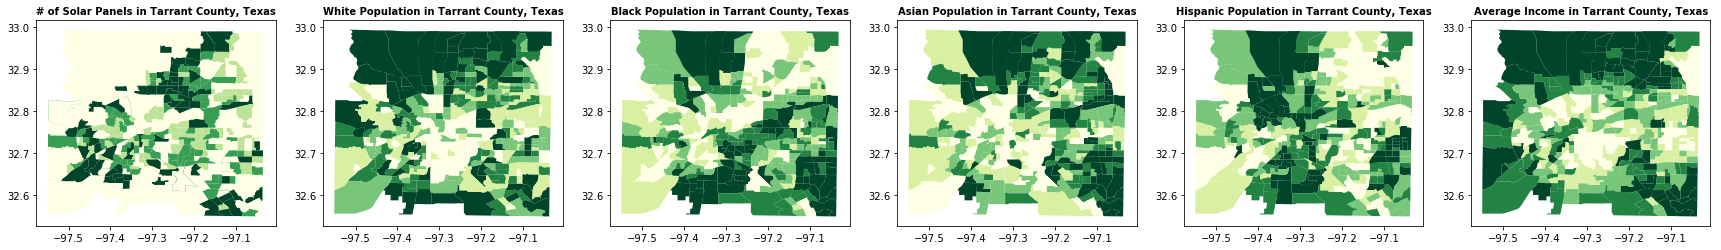

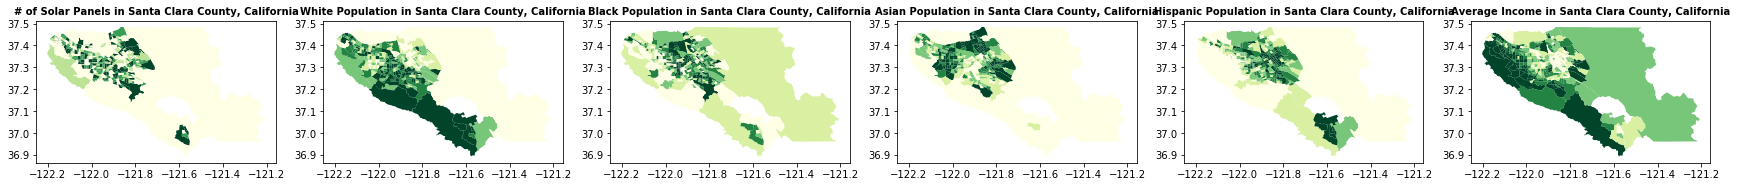

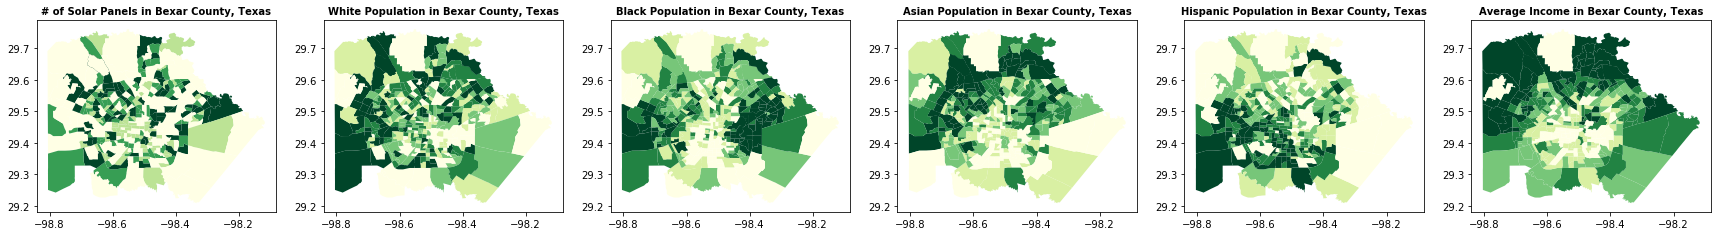

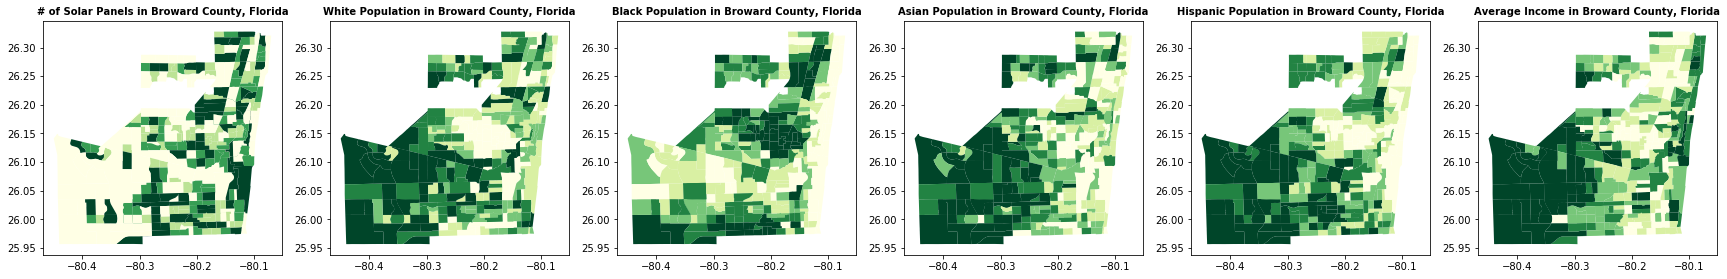

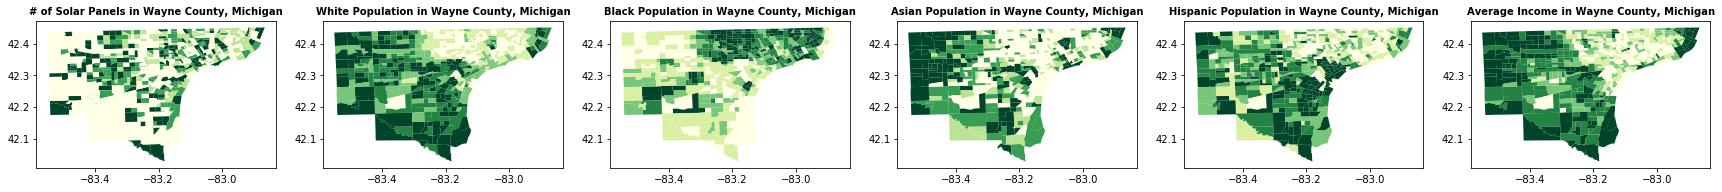

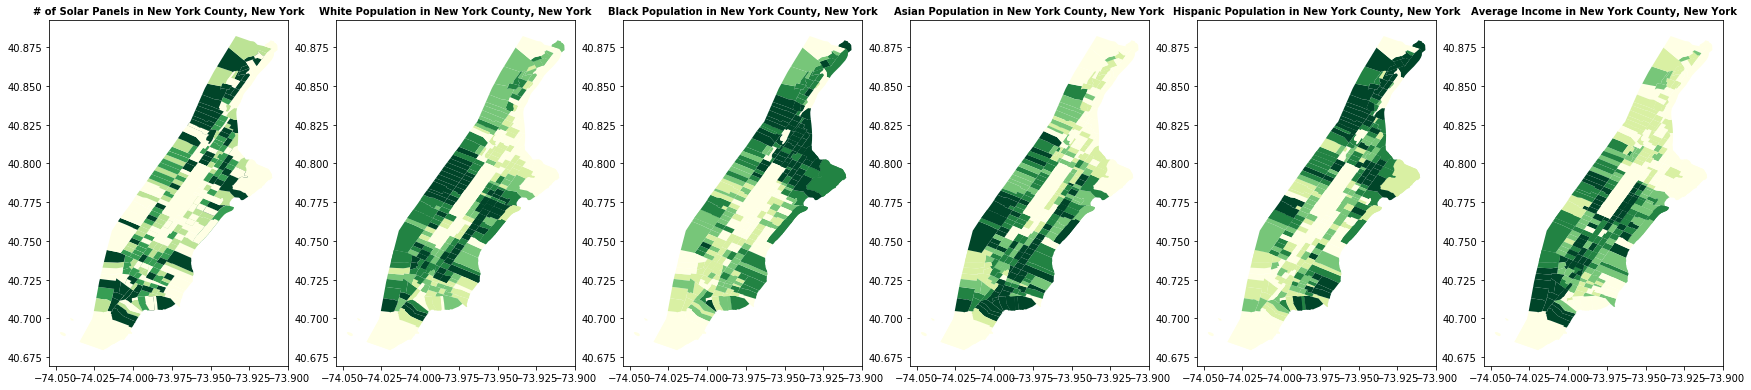

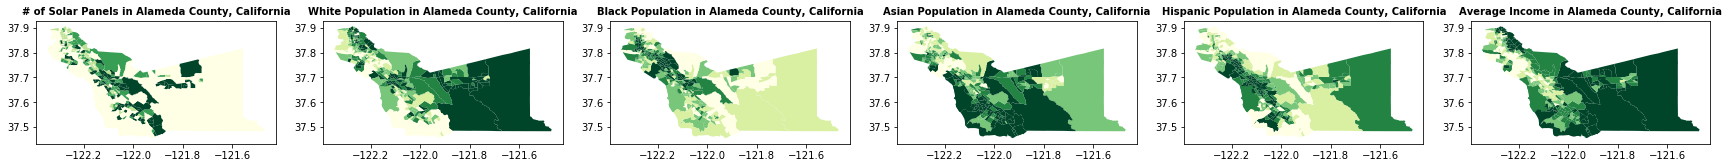

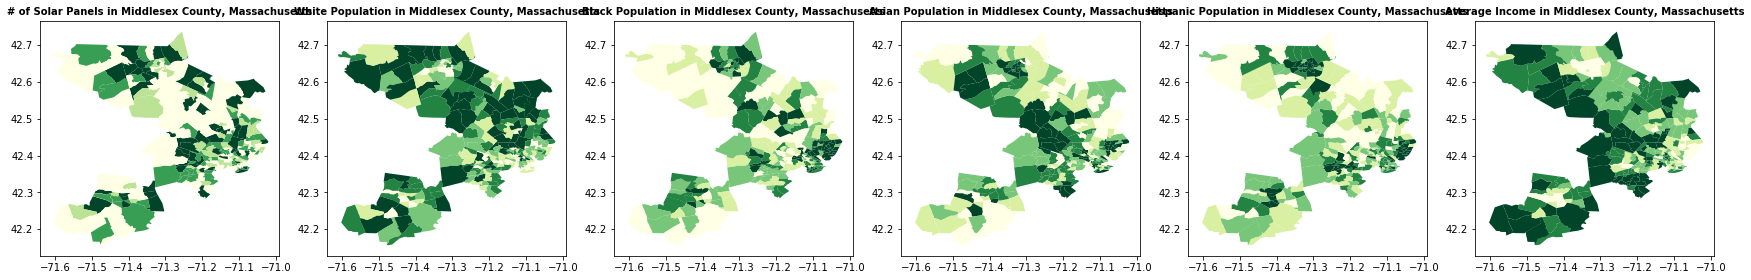

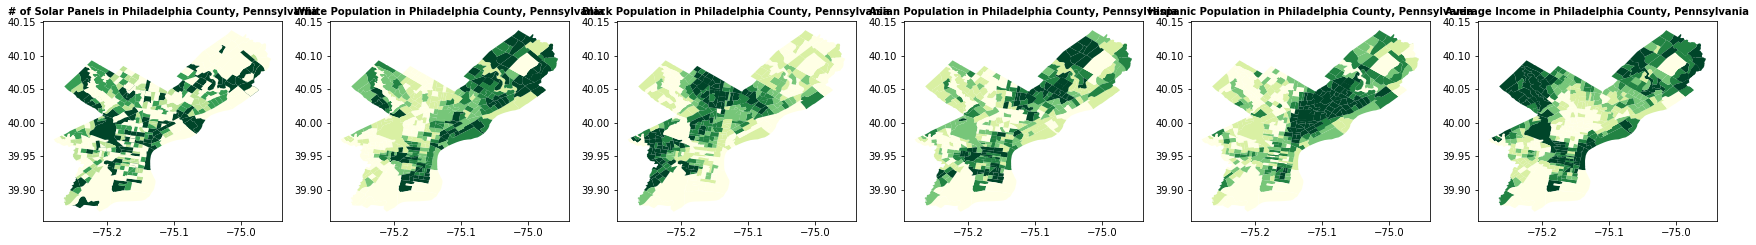

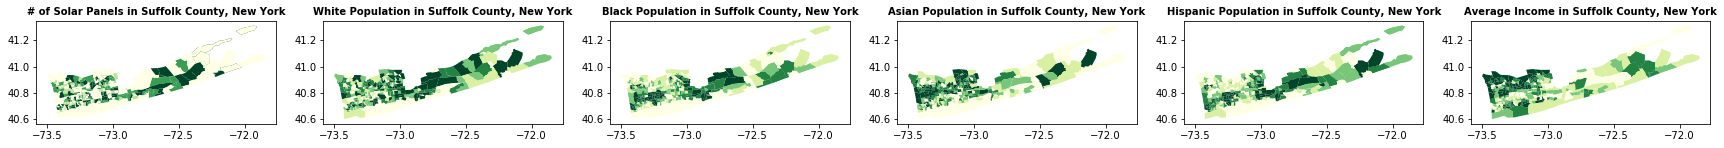

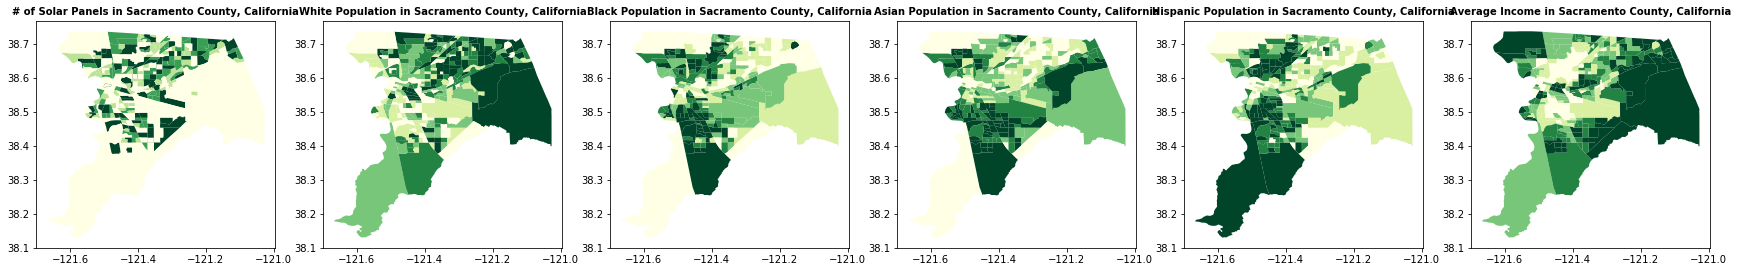

In [27]:
for x in range(0,len(toptracts)):
    fig,axs = plt.subplots(1, 6, figsize=(30,10))
    combined2[x].plot(ax = axs[0], column='number_of_panels_total', cmap='YlGn', scheme='quantiles').set_title('# of Solar Panels in '+ combined2[x].iloc[0]['CountyName'], fontsize=10, fontweight='bold')
    combined2[x].plot(ax = axs[1], column='White', cmap='YlGn', scheme='quantiles').set_title('White Population in '+ combined2[x].iloc[0]['CountyName'], fontsize=10, fontweight='bold')
    combined2[x].plot(ax = axs[2], column='Black', cmap='YlGn', scheme='quantiles').set_title('Black Population in '+ combined2[x].iloc[0]['CountyName'], fontsize=10, fontweight='bold')
    combined2[x].plot(ax = axs[3], column='Asian', cmap='YlGn', scheme='quantiles').set_title('Asian Population in '+ combined2[x].iloc[0]['CountyName'], fontsize=10, fontweight='bold')
    combined2[x].plot(ax = axs[4], column='Hispanic', cmap='YlGn', scheme='quantiles').set_title('Hispanic Population in '+ combined2[x].iloc[0]['CountyName'], fontsize=10, fontweight='bold')
    combined2[x].plot(ax = axs[5], column='Income', cmap='YlGn', scheme='quantiles').set_title('Average Income in '+ combined2[x].iloc[0]['CountyName'], fontsize=10, fontweight='bold')

In [50]:
countysortshort = countysort.head(1)
css = countysortshort
css
countyData = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[0,3], css.iloc[0,2], Census.ALL))
countyData.head()
countyData = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[0,3], css.iloc[0,2], Census.ALL))
for x in range(1,len(css)):
    df = pd.DataFrame(c.acs5.state_county_tract(('NAME', 'B01003_001E','B02001_002E', 'B02001_003E', 'B02001_005E', 'B03002_012E', 'B19013_001E'), css.iloc[x,3], css.iloc[x,2], Census.ALL))
    countyData = countyData.append(df, ignore_index = True)
    #print("I am at step ", x)
print('Out of Loop')
countyData.head()
countyData2 = pd.merge(countyData, css, on='county')
countyData2.head()
countyData2['tractID'] = countyData2['state_x'].str.cat(countyData2['county'],sep="").str.cat(countyData2['tract'], sep="")
censusdata = countyData2
censusdata.tractID = censusdata.tractID.astype(float)
censusdata.columns = ['TractPopulation', 'White', 'Black', 'Asian', 'Hispanic','Income', 'TractName', 'county', 'state', 'tract', 'CountyPopulation', 'CountyName', 'state2', 'GEOID']
censusdata = censusdata.drop(['tract', 'state2'], axis = 1)
#Edit the following line so that the "censusdata" dataframe is sorted by county population and then by geographic ID
censusdata.sort_values(["CountyPopulation", "GEOID"], axis = 0, ascending = [False, True], inplace=True)
censusdata.head()
censusdata = censusdata.drop(censusdata[censusdata.TractPopulation<1500].index)
censusdata = censusdata.drop(censusdata[censusdata.Income<0].index)
censusdata.reset_index(drop=True).head()
combined = pd.merge(censusdata,sunroofData)

Out of Loop


The following set of cells is my attempt at machine learning using the random forest technique introduced in class. I was not able to process much of the data that I would have liked, as attempts to perform the analysis on more than one county took much too long (estimated that two counties, LA and Cook County, IL, would have taken about two hours to process). Thus the random forest analysis was only performed on the largest county (Los Angeles County, CA). 

In [51]:
combined.fillna(0)
values = {'number_of_panels_total':0}
combined.fillna(value=values)
combined.head()

TractPopulation   White  Black  Asian  Hispanic   Income  \
0           4566.0  3374.0   52.0  282.0    1695.0  51209.0   
1           3064.0  2583.0    0.0  253.0     274.0  85460.0   
2           6043.0  4705.0  172.0  149.0    3187.0  34627.0   
3           3340.0  2249.0   53.0  395.0    1019.0  40273.0   
4           4285.0  3734.0  112.0  245.0     398.0  81076.0   

                                           TractName county state  \
0  Census Tract 1011.10, Los Angeles County, Cali...    037    06   
1  Census Tract 1011.22, Los Angeles County, Cali...    037    06   
2  Census Tract 1012.10, Los Angeles County, Cali...    037    06   
3  Census Tract 1012.20, Los Angeles County, Cali...    037    06   
4  Census Tract 1013, Los Angeles County, California    037    06   

   CountyPopulation           ...            yearly_sunlight_kwh_n  \
0        10105722.0           ...                     140187.74881   
1        10105722.0           ...                     276996.80946   
2        10105722.0           ...                     295955.81687   
3        10105722.0           ...                      95976.70462   
4        10105722.0           ...                     442640.01109   

   yearly_sunlight_kwh_s yearly_sunlight_kwh_e  yearly_sunlight_kwh_w  \
0           5.557341e+06          1.884887e+06           3.657478e+06   
1           7.289458e+06          3.498169e+06           5.085950e+06   
2           3.007513e+06          7.046530e+05           1.560988e+06   
3           3.039491e+06          1.470995e+06           2.467520e+06   
4           8.054853e+06          4.014203e+06           4.341075e+06   

   yearly_sunlight_kwh_f  yearly_sunlight_kwh_median  \
0           4.313453e+06                10214.202844   
1           1.913791e+06                14681.464380   
2           8.864574e+06                12548.251587   
3           2.862239e+06                10229.786316   
4           8.763948e+06                14164.059668   

   yearly_sunlight_kwh_total  \
0               1.555335e+07   
1               1.806436e+07   
2               1.443368e+07   
3               9.936221e+06   
4               2.561672e+07   

                        install_size_kw_buckets_json  \
0  [[0,347],[5,461],[10,156],[15,55],[20,15],[25,...   
1  [[0,201],[5,439],[10,340],[15,135],[20,38],[25...   
2  [[0,167],[5,157],[10,78],[15,35],[20,23],[25,2...   
3  [[0,213],[5,254],[10,116],[15,34],[20,13],[25,...   
4  [[0,238],[5,501],[10,360],[15,132],[20,50],[25...   

   carbon_offset_metric_tons  existing_installs_count  
0                4240.324983                     12.0  
1                4924.906272                     43.0  
2                3935.070036                      0.0  
3                2708.922091                      7.0  
4                6983.912268                     24.0  

[5 rows x 42 columns]

In [52]:
combined['logWhite'] = combined['White']
combined['logBlack'] = combined['Black']
combined['logAsian'] = combined['Asian']
combined['logHispanic'] = combined['Hispanic']
combined['logIncome'] = combined['Income']
combined.replace(np.nan,0,inplace=True)

In [53]:
train_vars = ['logWhite', 'logBlack', 'logAsian', 'logHispanic', 'logIncome']
trX, teX, trY, teY = train_test_split(combined[train_vars], combined['number_of_panels_total'], test_size =.25)

In [54]:
rf = RandomForestClassifier()
param_dist = {"n_estimators": stats.randint(2, 300), "max_features": ['sqrt',  'log2'], "min_samples_split": stats.randint(5, 50),"bootstrap": [True, False],"criterion": ["gini", "entropy"]}
random_rf = RandomizedSearchCV(rf, param_distributions=param_dist,n_iter=5, cv=5, verbose=1, n_jobs=-1)
random_rf.fit(trX, trY)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Vincent\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 11.7min finished
C:\Users\Vincent\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026986DD6CF8>, 'max_features': ['sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026986DD6D68>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None,

In [55]:
random_rf.score(teX, teY)

0.060955518945634266

This score is very low, and really tells us that there isn't really any correlation between any of our designated population demographic variables and the outcome of solar panel uptake, at least in the way that we have configured the analysis. 

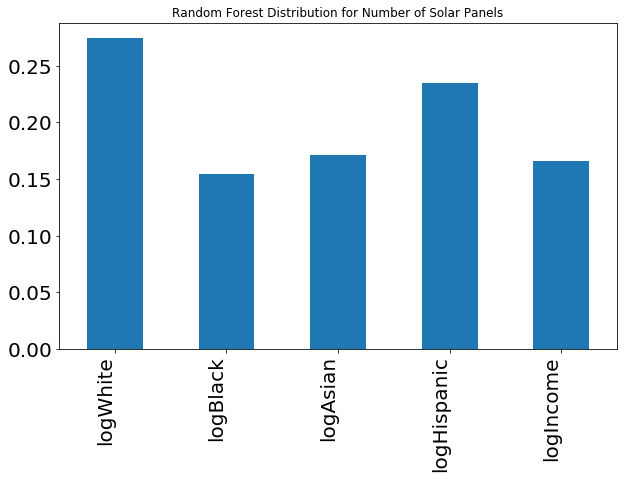

In [56]:
ax = pd.DataFrame(random_rf.best_estimator_.feature_importances_).plot(kind='bar',fontsize=20,figsize=(10,6))
ax.set_title('Random Forest Distribution for Number of Solar Panels')
ax.set_xticklabels(train_vars, rotation = 90, ha="right")
ax.get_legend().remove()

There is not a clear dominant factor for solar panel uptake. 

## Conclusion
My analysis indicates that there isn't a clear dominant factor for uptake of solar panel technology (at least in LA county). A visual observation of the choropleth maps of the 25 largest counties by population also does not yield any conclusions either. 

## Reflections
I really liked what one of our speakers said about just making the code work. I think that this project was a constant balancing act of understanding enough of the syntax and actually making the code work. There were times where the code seemed like a black box to me and then there were times where I really needed to understand what was going on to move on to the next step. 
If I were to have more time, I would find a faster way to run the random forest analysis such that I could look at more of the populous counties. Also, Professor Sunter had decided to only analyze those census tracts that were populated by one racial group by 50% or more. This may have made her analysis stronger. 